2D Diffusion:
\begin{split}
\frac{\partial \phi}{\partial t} = D \left( \frac{\partial^2 \phi}{\partial x^2} + \frac{\partial^2 \phi}{\partial y^2} \right)
\end{split}

Discretize, using second order centered difference and implicit timestep:

\begin{split}
\frac{\phi_{i,j} - \phi_{i,j}^{old}}{\Delta t}
=
D
\left( \frac{\phi_{i+1,j} - 2 \phi_{i,j} + \phi_{i-1,j}}{\Delta x^2}
+
\frac{\phi_{i,j+1} - 2 \phi_{i,j} + \phi_{i,j-1}}{\Delta y^2}
\right)
\end{split}

Group terms to construct system matrix:

\begin{split}
\phi_{i+1,j}\left(\frac{D}{\Delta x^2}\right)
+ \phi_{i-1,j}\left(\frac{D}{\Delta x^2}\right)
+ \phi_{i,j+1}\left(\frac{D}{\Delta y^2}\right)
+ \phi_{i,j-1}\left(\frac{D}{\Delta y^2}\right)
+ \phi_{i,j}\left(\frac{-2D}{\Delta x^2} + \frac{-2D}{\Delta y^2} + \frac{-1}{\Delta t}\right)
= \frac{- \phi_{i,j}^{old}}{\Delta t}
\end{split}

Removing transient terms:

\begin{split}
\phi_{i+1,j}\left(\frac{D}{\Delta x^2}\right)
+ \phi_{i-1,j}\left(\frac{D}{\Delta x^2}\right)
+ \phi_{i,j+1}\left(\frac{D}{\Delta y^2}\right)
+ \phi_{i,j-1}\left(\frac{D}{\Delta y^2}\right)
+ \phi_{i,j}\left(\frac{-2D}{\Delta x^2} + \frac{-2D}{\Delta y^2} \right)
= 0
\end{split}

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import scipy

from copy import deepcopy

In [69]:
NX = 51
NY = 51
LX = 0.5
LY = 0.5
dx = LX / (NX - 1)
dy = LY / (NY - 1)
print(dx, dy)
NG = NX * NY
D = 0.1
BC_TOP = 1.0  # x = all, y = LY
BC_BOTTOM = 0.0  # x = all, y = 0
BC_LEFT = 0.0  # x = 0, y = all
BC_RIGHT = 0.0  # x = LX, y = all


0.01 0.01


In [70]:
A = np.zeros((NG, NG))
b = np.zeros(NG)

for jdx in range(NY):
    for idx in range(NX):
        # define ij to index rows and columns of system matrix
        ij = jdx * NY + idx
        # the rows of the matrix correspond to output. as such, indexing adjacent nodes should be done via the columns.
        # example: A[(ij), (i+/-1, j+/-1)]
        im1 = jdx * NY + idx - 1
        ip1 = jdx * NY + idx + 1
        jm1 = (jdx - 1) * NY + idx
        jp1 = (jdx + 1) * NY + idx
        # set main diagonal
        A[ij, ij] = (-2 * D) / (dx**2) + (-2 * D) / (dy**2)

        # set RHS
        b[ij] = 0

        IS_BOUNDARY_POINT = (
            (jdx == 0 or jdx == NY - 1)
            or (idx == 0 or idx == NX - 1)
            )

        if IS_BOUNDARY_POINT:
            A[ij, ij] = 1
            if jdx == 0:
                b[ij] = BC_BOTTOM
            if jdx == NY - 1:
                b[ij] = BC_TOP
            if idx == 0:
                b[ij] = BC_LEFT
            if idx == NX - 1:
                b[ij] = BC_RIGHT
        else:  # set banded diagonals
            if im1 >= 0:
                A[ij, im1] = D / (dx**2)
            if ip1 < NG:
                A[ij, ip1] = D / (dx**2)
            if jm1 >= 0:
                A[ij, jm1] = D / (dy**2)
            if jp1 < NG:
                A[ij, jp1] = D / (dy**2)
  

In [71]:
if False:
    with open("finite_diff_example_diffusion_system_matrix.csv", "w") as f:
        for i, row in enumerate(A):
            for entry in row:
                f.write(f"{round(entry):4}")
            f.write("\n")

In [72]:
A.shape, b.shape, 51 * 51

((2601, 2601), (2601,), 2601)

In [73]:
# least squares solver only works because matrix is invertible lol. not possible for larger matrices.
phi = np.linalg.inv(A.T @ A) @ A.T @ b

In [74]:
# TODO: write solver

In [75]:
phi

array([ 0.00000000e+00, -1.49820158e-12, -3.63332973e-12, ...,
        9.99999995e-01,  1.00000000e+00,  0.00000000e+00], shape=(2601,))

In [76]:
sol = np.zeros((NX, NY))

for jdx in range(NY):
    for idx in range(NX):
        ij = jdx * NY + idx
        sol[idx, jdx] = phi[ij]

Text(0.5, 0, 'Z Label')

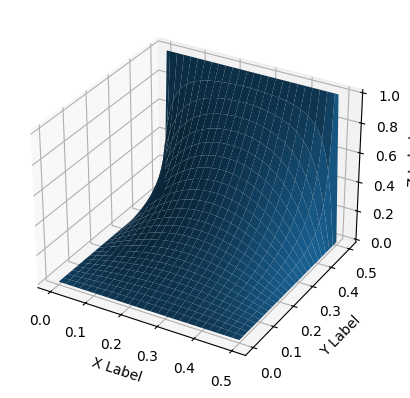

In [77]:
xgrid, ygrid = np.meshgrid(np.linspace(0, LX, NX), np.linspace(0, LY, NY), indexing="ij")

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(xgrid, ygrid, sol)

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')